In [1]:
import datastore

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

cons_gwh = datastore.getConsumptionGWh()

nuclear_finland_germany_mwh = datastore.getHourlyProduction_nuclear_EU()
germany_all = datastore.getHourlyProduction_Germany_all()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

otherData = datastore.getOtherNordPoolData()

hydroReservoirs = datastore.getWeeklyHydroReservs()

temp_pen = datastore.getDailyWeather()

# stationCap = datastore.getStationCap_forecast()
# transTo = datastore.getTransmissionCapTo_forecast()
# transFrom = datastore.getTransmissionCapFrom_forecast()

# productionCap = datastore.getProductionCap_forecast()


Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionSE1GWh', 'ConsumptionSE2GWh', 'ConsumptionSE3GWh',
       'ConsumptionSE4GWh'],
      dtype='object') : 48
Missing values in Index(['nucFI(MWh)', 'nucDE(MWh)'], dtype='object') : 845
Missing values in Index(['wind(Mwh)', 'solar(Mwh)', 'trm(Mwh)', 'biomass(Mwh)', 'coal(MWh)',
       'gas(MWh)', 'oil(MWh)', 'lignite(MWh)', 'nuc(MWh)', 'pump(MWh)',
       'other(MWh)', 'waste(MWh)'],
      dtype='object') : 1384
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 148
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 342
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 385
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 353
Missing v

In [3]:
import numpy as np

dataset = pd.concat([spot, cons_gwh, production_se1_mwh, production_se2_mwh, 
                                    production_se3_mwh, production_se4_mwh, temp_pen], axis=1)

dataset.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [22]:
from sklearn.preprocessing import MinMaxScaler
import torch

def create_dataset(x, y, time_steps):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    x_seq, y_seq = [], []
    for i in range(len(x) - time_steps + 1):
        x_seq.append(x[i:i+time_steps]) # window of time steps
        y_seq.append(y[i+time_steps-1]) # target is the last value of the window

    x_seq = np.array(x)
    y_seq = np.array(y)
    
    print(x_seq.shape, y_seq.shape)
    return torch.tensor(x_seq), torch.tensor(y_seq)

x = dataset.drop('spotPrice', axis=1)
y = dataset['spotPrice'].values.reshape(-1, 1)

train_split = int(len(dataset) * 0.7)
validation_split = int(len(dataset) * 0.85)
test_split = len(dataset)

x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

x_train = x_scaler.fit_transform(x.values[:train_split])
y_train = y_scaler.fit_transform(y[:train_split])

x_val = x_scaler.transform(x.values[train_split:validation_split])
y_val = y_scaler.transform(y[train_split:validation_split])

x_test = x_scaler.transform(x.values[validation_split:test_split])
y_test = y_scaler.transform(y[validation_split:test_split])

# seq_length = 24
# x_train_seq, y_train_seq = create_dataset(x_train, y_train, seq_length)
# x_val_seq, y_val_seq = create_dataset(x_val, y_val, seq_length)
# x_test_seq, y_test_seq = create_dataset(x_test, y_test, seq_length)


In [ ]:
from torch.utils.data import TensorDataset,DataLoader

batch_size = 32

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_val = torch.tensor(x_val).float()
y_val = torch.tensor(y_val).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=batch_size)


In [44]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.unsqueeze(1).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.unsqueeze(1).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.unsqueeze(1).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.0081	 Validation loss: 0.1674
[2/100] Training loss: 0.0046	 Validation loss: 0.1762
[3/100] Training loss: 0.0037	 Validation loss: 0.1925
[4/100] Training loss: 0.0034	 Validation loss: 0.1827
[5/100] Training loss: 0.0032	 Validation loss: 0.1842
[6/100] Training loss: 0.0030	 Validation loss: 0.1769
[7/100] Training loss: 0.0029	 Validation loss: 0.1725
[8/100] Training loss: 0.0028	 Validation loss: 0.1778
[9/100] Training loss: 0.0027	 Validation loss: 0.1850
[10/100] Training loss: 0.0027	 Validation loss: 0.1900
[50/100] Training loss: 0.0017	 Validation loss: 0.2006
[100/100] Training loss: 0.0015	 Validation loss: 0.2045


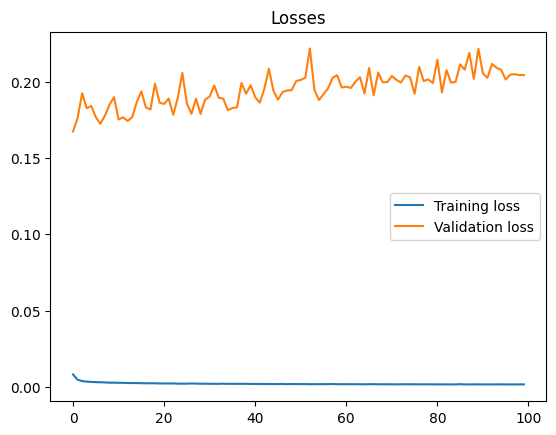

In [47]:
import LSTM
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
input_size = x_train.shape[1]
hidden_layer_size = 256
output_size = 1
num_layers = 1

model = LSTM.LSTM(input_size=input_size, hidden_size=hidden_layer_size, 
                  output_size=output_size, num_layers=num_layers)


learning_rate = 0.01
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()

batch_size = 32
opt = Optimization(model, loss_fn, optimizer)
opt.train(train_dl, val_dl, batch_size = batch_size, n_epochs=epochs, n_features=input_size)
opt.plot_losses()

predictions, values = opt.evaluate(val_dl, batch_size=1, n_features=input_size)

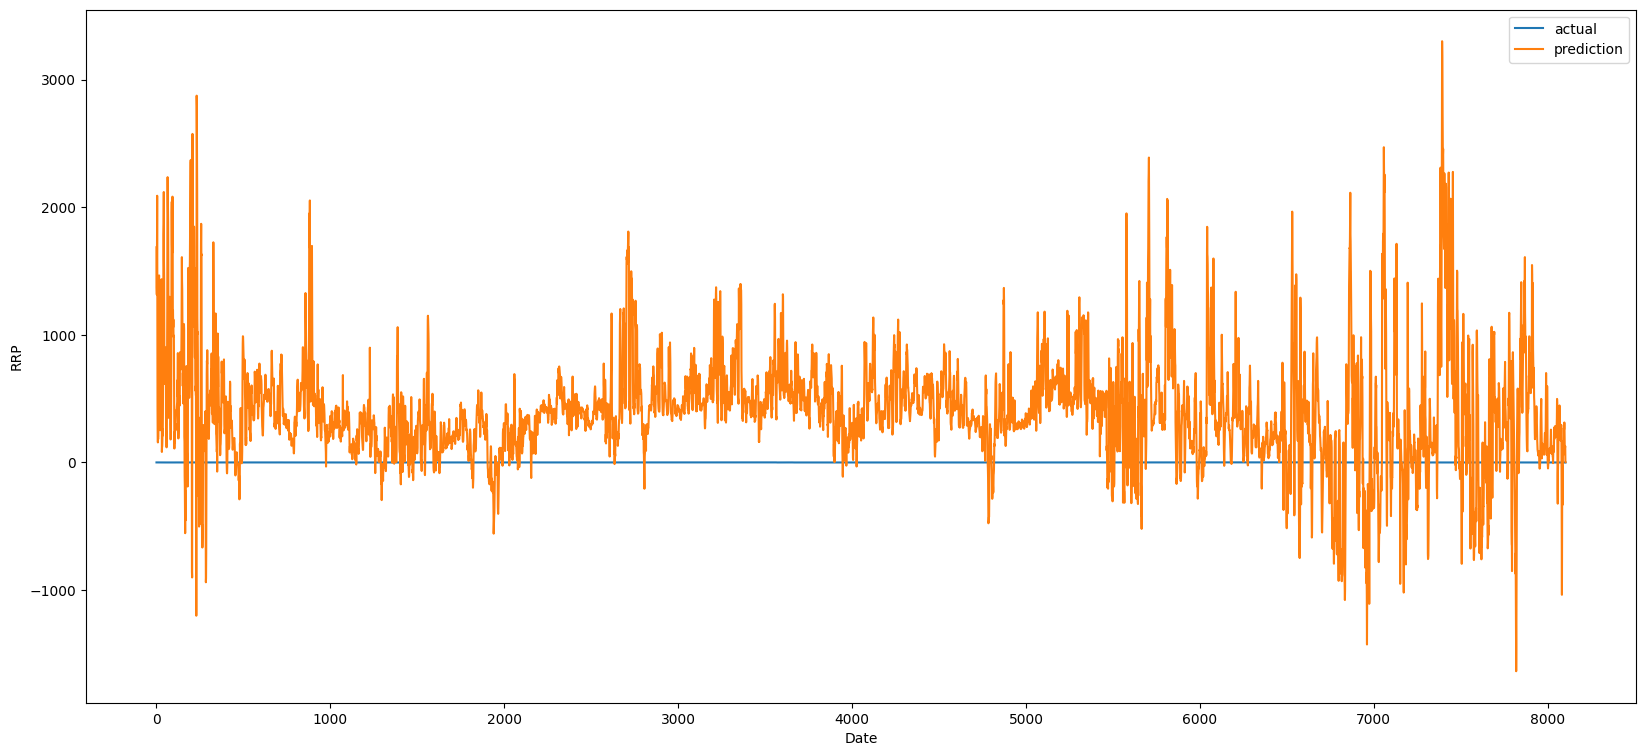

In [54]:
#Create a function for plotting
def plot_forecast(y_test, y_pred, ci=None):
    plt.rcParams["figure.figsize"] = 20,9
    ax = y_test.plot(label='Observed')
    y_pred.plot(ax=ax, label='Forecast')
    try:
      ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='g', alpha=.25)
    except AttributeError:
      pass

    plt.xlabel('Date')
    plt.ylabel('RRP')
    plt.legend()
    plt.show()

preds = np.concatenate(predictions, axis=0).ravel()
preds = y_scaler.inverse_transform(preds.reshape(-1, 1))

preds = pd.DataFrame(preds, columns=['prediction'])
plot_forecast(pd.DataFrame(y_test, columns=['actual']), preds)